## Last lecture: Reading-papers 

## DeepQLearning: 

#### Key-1: Fix Target
#### Key-2: Memory Replay

In [1]:
import time
from collections import defaultdict

import gymnasium as gym
import numpy as np
import random

from matplotlib import pyplot as plt, animation

## Homework - Lecture-04
#### 1. 我们把lunarlander-通过-DQN跑起来
#### 2. 我们把lunarlander的state改成此时此刻的env.render() 
#### 3. 我们通过CNN 来处理env.render() [图像] 
#### 4. 学习DQN Paper的：灰度处理，resize，stacked

In [2]:
# 声明Env
env = gym.make("LunarLander-v2", render_mode='rgb_array')

In [3]:
env.reset()
env.action_space.sample()
env.render().shape

(400, 600, 3)

In [22]:
state, info = env.reset()

tst_frames = []

for _ in range(10): 
    while True: 
        state_n, reward, truncated, done, info = env.step(env.action_space.sample())

        tst_frames.append(env.render())

        if truncated or done: 
            break 

In [31]:
tst_frames[1].shape

(400, 600, 3)

## 休息：12：000 继续

In [5]:
gamma = 0.99

# 计算state维度
taxi_row = 24
taxi_col = 24
passenger_location = 4
destination = 3
total_count = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

# 声明Q_table

# 学习率
alpha = 0.9
# 折扣因子
gamma = 0.95

# 训练次数
episode = 10000

# DQN

In [34]:
class ExperienceBuffer:
    def __init__(self, size=0):
        self.states = []
        self.next_states = []
        self.rewards = [] 
        self.actions = []
        self.next_actions = []
        self.size = 0
        
    def clear(self):
        self.__init__()
        
    def append(self, s, n_s, r, a, n_a):
        self.states.append(s)
        self.next_states.append(n_s)
        self.rewards.append(r)
        self.actions.append(a)
        self.next_actions.append(n_a)
        self.size += 1
    
    def batch(self, batch_size=128):
        # return 'bath_size' experiences
        indices = np.random.choice(self.size, size=batch_size, replace=True)
        
        return (
            np.array(self.states)[indices],
            np.array(self.next_states)[indices],
            np.array(self.rewards)[indices],
            np.array(self.actions)[indices],
            np.array(self.next_actions)[indices],
        )

In [35]:
from tqdm import tqdm_notebook

In [36]:
import torch

In [37]:
from torch import nn
from torch.nn.functional import relu

In [38]:
class DQN(nn.Module):
    def __init__(self, action_size): 
        super().__init__()
        self.action_size = action_size
        state_size = 4
        hidden_size = 8
        # CNN: <- Image (人眼看到的图像)
        self.linear = nn.Linear(state_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, action_size)
        
        nn.init.uniform_(self.linear.weight, a=-0.1, b=0.1)
        nn.init.uniform_(self.linear_2.weight, a=-0.1, b=0.1)
    
    def forward(self, state):
        if not isinstance(state, torch.Tensor): 
            state = torch.tensor([state], dtype=torch.float)
        return self.linear_2(relu(self.linear(state)))

In [39]:
import torch.nn.functional as F

In [40]:
torch.multinomial(F.softmax(torch.tensor([0, 0, 0], dtype=torch.float)), num_samples=1)

/var/folders/d8/0s3c3vcs47qccb955ykczzkm0000gn/T/ipykernel_9753/3409072381.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.multinomial(F.softmax(torch.tensor([0, 0, 0], dtype=torch.float)), num_samples=1)


tensor([1])

In [41]:
def policy(model, state, _eval=False):
    eps = 0.1
    
    if not _eval and random.random() < eps: 
        # exploration
        return random.randint(0, model.action_size-1)
    else:
        # exploitation
        q_values = dqn_model(torch.tensor([state], dtype=torch.float))
        action = torch.multinomial(F.softmax(q_values), num_samples=1)
        return int(action[0])

In [42]:
import numpy as np

In [43]:
dqn_model = DQN(action_size=2)
target_model = DQN(action_size=2)

In [44]:
s, _ = env.reset()

In [45]:
policy(dqn_model, s)

/var/folders/d8/0s3c3vcs47qccb955ykczzkm0000gn/T/ipykernel_9753/134373928.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = torch.multinomial(F.softmax(q_values), num_samples=1)


0

In [46]:
dqn_model(torch.tensor([s], dtype=torch.float))

tensor([[-0.2634,  0.2337]], grad_fn=<AddmmBackward0>)

In [47]:
from tqdm import tqdm_notebook

In [48]:
# 进行Q_table的训练

experience_buffer = ExperienceBuffer()

eval_iter = 100 
eval_num = 100

# collect
def collect():
    for e in tqdm_notebook(range(episode)):
        # trajectory = []
        state, info = env.reset()
        # print(info["action_mask"])
        # a = env.action_space.sample(info["action_mask"])
        action = policy(dqn_model, state)

        sum_reward = 0 

        while True:
            state_next, reward, terminated, truncated, info_next = env.step(action)

            sum_reward += reward 

            action_next = policy(dqn_model, state_next)

            experience_buffer.append(
                state, state_next, reward, action, action_next
            )
            if terminated or truncated:
                break

            state = state_next
            info = info_next
            action = action_next

In [49]:
from torch.optim import Adam

In [50]:
adam = Adam(lr=1e-3, params=dqn_model.parameters())

In [51]:
loss_fn = nn.MSELoss()

In [52]:
## learning
losses = []
target_fix_period = 5 
gamma = 0.99 

epoch = 3

def train():
    for e in range(epoch):
        batch_size = 512
        for i in range(experience_buffer.size // batch_size):
            print(i, end=',')
            s, s_n, r, a, a_n = experience_buffer.batch(batch_size) 

            y = torch.tensor(r, dtype=torch.float) + gamma * target_model(s_n)[0][torch.arange(batch_size), a_n]
            y_hat = dqn_model(s)[0][torch.arange(batch_size), a]

            loss = loss_fn(y, y_hat)
            loss.backward()
            adam.zero_grad()
            adam.step()
            losses.append(loss.detach().numpy())

            if i % 10 == 0: 
                print(f'i == {i}, loss = {loss} ')

            if i % target_fix_period == 0: 
                ## copy the paramters from 'dqn_model' to 'target_model'
                target_model.load_state_dict(dqn_model.state_dict())

## 为什么 loss 可以这么设置

#### 上上一节课：q-learning， q-table 不需要把sampling全部跑完
#### SARSA -> q-learning 
#### q-learning(state) -> [q_a_1, q_a_2, q_a_3, .. q_a_N]
#### q-learning not a TABLE -> function
#### Q(state, action) = reward + Q(next_state, next_action) 
#### Q -> unknown? 
#### Q(state, action) {未知，随机初始的 } = reward + Q(next_state, next_action)  {未知，随机初试的}
#### reward -> 真实的反馈
#### {Q(state, action) } - > A     {reward + Q(next_state, next_action) } -> B
#### A 和 B 谁的信息，更接近真实值
#### $function: Q(s, a) = \sum_{i \in ||S||}{w_i}x_i + b_i$
#### $loss = (r + \gamma * Q(s', a') - Q(s, a))^2$

In [53]:
for i in range(1):
    print(f'collect/train: {i}')
    experience_buffer.clear()
    collect()
    train()

collect/train: 0


/var/folders/d8/0s3c3vcs47qccb955ykczzkm0000gn/T/ipykernel_9753/208558859.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(episode)):


  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/d8/0s3c3vcs47qccb955ykczzkm0000gn/T/ipykernel_9753/134373928.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = torch.multinomial(F.softmax(q_values), num_samples=1)


0,i == 0, loss = 0.7399462461471558 
1,2,3,4,5,6,7,8,9,10,i == 10, loss = 1.1065856218338013 
11,12,13,14,15,16,17,18,19,20,i == 20, loss = 1.0938310623168945 
21,22,23,24,25,26,27,28,29,30,i == 30, loss = 1.1038587093353271 
31,32,33,34,35,36,37,38,39,40,i == 40, loss = 1.102783203125 
41,42,43,44,45,46,47,48,49,50,i == 50, loss = 1.1961510181427002 
51,52,53,54,55,56,57,58,59,60,i == 60, loss = 1.0714787244796753 
61,62,63,64,65,66,67,68,69,70,i == 70, loss = 1.1180622577667236 
71,72,73,74,75,76,77,78,79,80,i == 80, loss = 1.1409262418746948 
81,82,83,84,85,86,87,88,89,90,i == 90, loss = 1.1311897039413452 
91,92,93,94,95,96,97,98,99,100,i == 100, loss = 1.122148036956787 
101,102,103,104,105,106,107,108,109,110,i == 110, loss = 1.187559723854065 
111,112,113,114,115,116,117,118,119,120,i == 120, loss = 1.0981289148330688 
121,122,123,124,125,126,127,128,129,130,i == 130, loss = 1.1003994941711426 
131,132,133,134,135,136,137,138,139,140,i == 140, loss = 1.1272547245025635 
141,142,

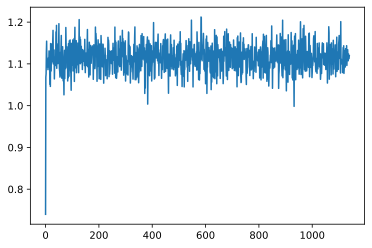

In [54]:
plt.plot(losses)

# 模型效果可视化

In [408]:
task_num = 10
frames = []

for _ in range(10):
    state, _ = env.reset()
    while True:
        action = policy(dqn_model, state, _eval=True)
        state_next, reward, terminated, truncated, info_next = env.step(action)
        frames.append(env.render())

        if terminated or truncated:
            break

/var/folders/d8/0s3c3vcs47qccb955ykczzkm0000gn/T/ipykernel_19557/2469254241.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = torch.multinomial(F.softmax(q_values), num_samples=1)


In [7]:
%matplotlib notebook

In [8]:
from matplotlib import animation

In [12]:
def animate_method_1(frames):
#    def update(frame):
#        plt.imshow(frame)
    
    anim = animation.FuncAnimation(plt.gcf(), lambda f: plt.imshow(f), frames=frames, interval=1, repeat_delay=50)

#animate_method_1(frames)

<IPython.core.display.Javascript object>


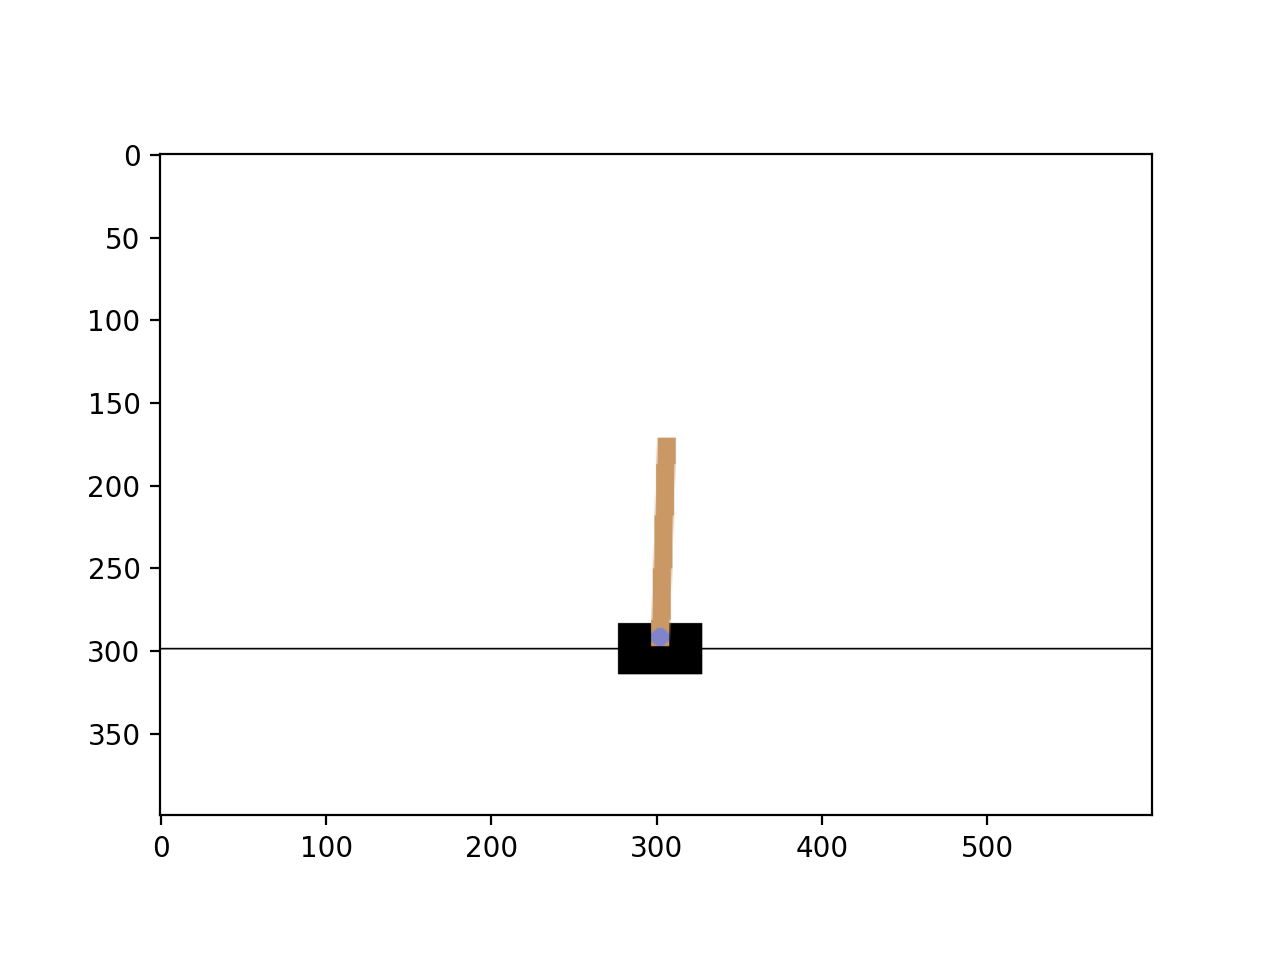

In [14]:
animate_method_1(tst_frames)